<center><h1>Introduction to image processing - Color transfer</h1>

# Introduction
For the following exercices, you need Python 3 with some basic librairies (see below).
All images necessary for the session are available [here](https://github.com/judelo/notebooks/tree/master/im). 

If you use your own Python 3 install, you should download the images, put them in a convenient directory and update the path in the next cell.

For some parts of the session (cells with commands written as `todo_something`...), you are supposed to code by yourself.   

In [1]:
path = '../im/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

The following line will be used to import the solutions of the practical session. Do not use it for the moment.

In [3]:
from TP_color_transfer import *

**Load and display a color image**. A color image is made of three channels : red, green and blue. A color image in $\mathbb{R}^{N\times M}$ is stored as a $N\times M\times 3$ matrix.


<span style="color:red">
    
**Be careful with the functions `plt.imread()` and `plt.imshow()` of `matplotlib`.** 
- `plt.imread()` reads png images as numpy arrays of floating points between 0 and 1, but it reads jpg or bmp images as numpy arrays of 8 bit integers. 

- **In this practical session, we assume floating point images between 0 and 1, so if you use jpg or bmp images, you should normalize them to $[0,1]$.** 

- If 'im' is an image encoded as a double numpy array, `plt.imshow(im)` will display all values above 1 in white and all values below 0 in black. If the image 'im' is encoded on 8 bits though, `plt.imshow(im)` will display 0 in black and 255 in white.</span>

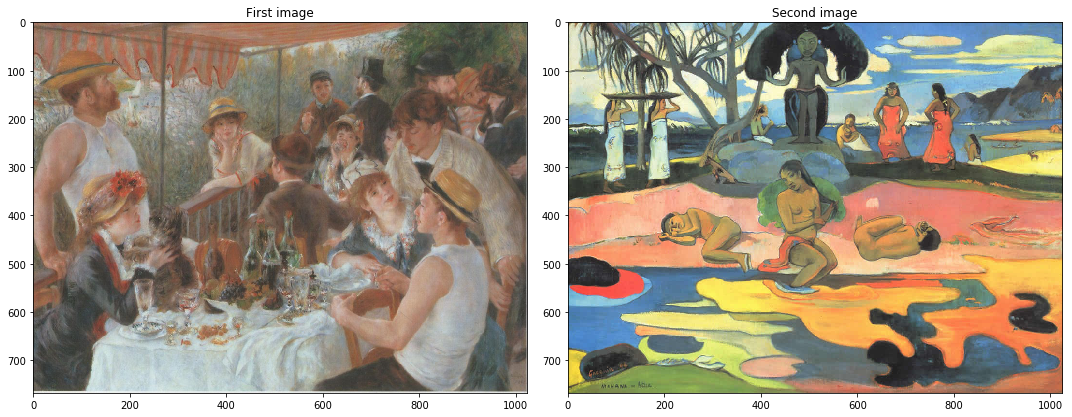

In [4]:
imrgb1 = plt.imread(path+'renoir.jpg')/255
imrgb2 = plt.imread(path+'gauguin.jpg')/255
imrgb1=imrgb1[:,:,0:3] # useful if the image is a png with a transparency channel
imrgb2=imrgb2[:,:,0:3] 

#we display the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axes[0].imshow(imrgb1)
axes[0].set_title('First image')
axes[1].imshow(imrgb2)
axes[1].set_title('Second image')
fig.tight_layout()

# Separable color transfer

## Separable affine transfer

Write a function `affine_transfer` which apply an affine transform to an image $u$ such that it has the same mean and the same standard deviation as $v$ on each channel.

In [5]:
def affine_transfer(u,v):
    w = np.zeros(u.shape)
    for i in range(0,3):
        w[:,:,i] = (u[:,:,i] -np.mean(u[:,:,i]))/np.std(u[:,:,i])*np.std(v[:,:,i])+ np.mean(v[:,:,i])
    return w

Display and comment the result. 

In [6]:
w = affine_transfer(imrgb1,imrgb2)
w = (w>1)+(w<=1)*(w>0)*w      # w should be in [0,1]

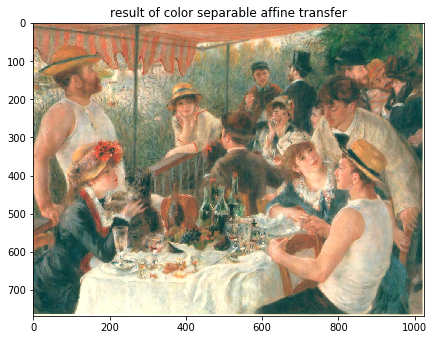

In [7]:
plt.figure(figsize=(7, 7))
plt.title('result of color separable affine transfer')
plt.imshow(w)

## Separable specification

Another solution consists in applying histogram specifications separately on each channel of the images $u$ and $v$. 

- **Write a function `todo_specification_separate_channels(imrgb1,imrgb2)` which take two images $u$ and $v$ as input, and apply color specification separately on each channel (see the practical session on radiometry).**   

In [8]:
w = todo_specification_separate_channels(imrgb1,imrgb2)
w = (w>1)+(w<=1)*(w>0)*w      # w should be in [0,1]

Display and comment the result. 

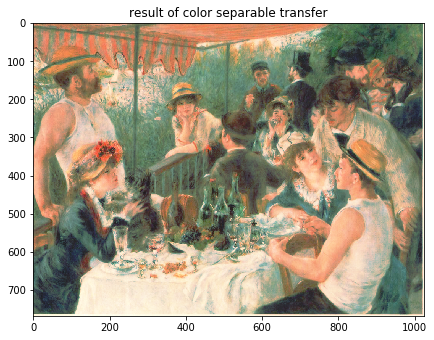

In [9]:
plt.figure(figsize=(7, 7))
plt.title('result of color separable transfer')
plt.imshow(w)

# Sliced optimal transport

In order to transport the full color distribution of $u$ on the one of $v$, we propose to write these distributions as 3D point clouds 

$$X = \begin{pmatrix} X_1 \\ \vdots\\ X_n \end{pmatrix}, \;\;\text{ and }\;\; Y  = 
  \begin{pmatrix}
    Y_1 \\
\vdots\\
Y_n
  \end{pmatrix},
$$

with $n$ the number of pixels in $u$ and $v$, $X_i$ the color $(R_i,G_i,B_i)$ of the $i$-th pixel in $u$ and $Y_i$ the color of the $i$-th pixel in $v$ ($X$ and $Y$ are $n\times 3$ matrices). We look for the permutation $\sigma$ of $\{1,\dots, n\}$ which minimizes the  quantity  
\begin{equation}
 \label{eq:transport_appariement}
 \sum_{i=1}^n \|X_i - Y_{\sigma(i)}\|^2_2.
\end{equation}   
The assignment $\sigma$ defines a mapping between the set of colors $\{X_i\}_{i=1,\dots n}$ and the set of colors $\{Y_j\}_{j=1,\dots n}$.


## Transport in 1D

In one dimension, the assignment $\sigma$ which minimizes the previous cost is the one which preserves the ordering of the points. More precisely, if $\sigma_X$ and $\sigma_Y$ are the permutations such that 
$$X_{\sigma_X(1)} \leq X_{\sigma_X(2)} \leq \dots \leq X_{\sigma_X(n)},$$
$$Y_{\sigma_Y(1)} \leq Y_{\sigma_Y(2)} \leq \dots \leq Y_{\sigma_Y(n)},$$
then $\sigma =  \sigma_Y \circ \sigma_X^{-1}$ minimizes the previous cost. 

The following function ~transport1D~ takes two 1D point clouds $X$ and $Y$ and return the permutations $\sigma_X$ and $\sigma_Y$. 


In [10]:
def transport1D(X,Y):
    sx = np.argsort(X) #argsort retourne les indices des valeurs s'ils étaient ordonnés par ordre croissant   
    sy = np.argsort(Y)
    return((sx,sy)) 

##  Sliced 3D Transport

Finding the solution of the assignment problem in more than one dimension is computationnaly demanding. Instead of computing the explicit solution, we make use of a stochastic gradient descent algorithm which computes the solution of a sliced approximation of the optimal transport problem over 1D distributions (see the following [paper](http://hal.archives-ouvertes.fr/hal-00476064/fr/)). 

The algorithm starts from the point cloud $Z=X$. At each iteration, it picks a random orthonormal basis of $\mathbb{R}^3$, denoted by $(u_1,u_2,u_3)$, and for each $i=1,\dots 3$ it computes the gradient step
 
$$ Z_{\sigma_Z}  = Z_{\sigma_Z} + \varepsilon ( (Y,u_i)_{\sigma_Y} - (Z,u_i)_{\sigma_Z} ) u_i,$$

where $(\;,\;)$ is the scalar product in $\mathbb{R}^3$, $\sigma_Y$ and $\sigma_Z$ are the permutations that order the one-dimensionnal projected point clouds $\{(Y_j,u_i)\}_{j=1\dots n}$ and $\{(Z_j,u_i)\}_{j=1\dots n}$. This permutation at each iteration can be computed thanks to the function `transport1D` defined above.   

- **Write a function todo_transport3D(X,Y,N,e) implementing the previous iterations. The function should take as input the point clouds $X$ and $Y$, a number of iterations $N$ and a step $\epsilon$. The function should output a point cloud $Z$ and the permutations $\sigma_Z$ and $\sigma_X$**. 
- *Hints*: 
    + to initiate the point cloud $Z$ at $X$, you can use 
    
            Z = np.copy(X)
    
    + to pick an orthonormal basis, you can first draw a $\mathcal{N}(0,I)$ random vector in 3D and apply the QR algorithm to it,

            u=np.random.randn(3,3)
            q=np.linalg.qr(u)[0]
            
    + the scalar product between two 3D vectors $x$ and $y$ can be computed thanks to 
            
            np.dot(x,y)
           

Implement and test the previous code with random 3D point clouds. 

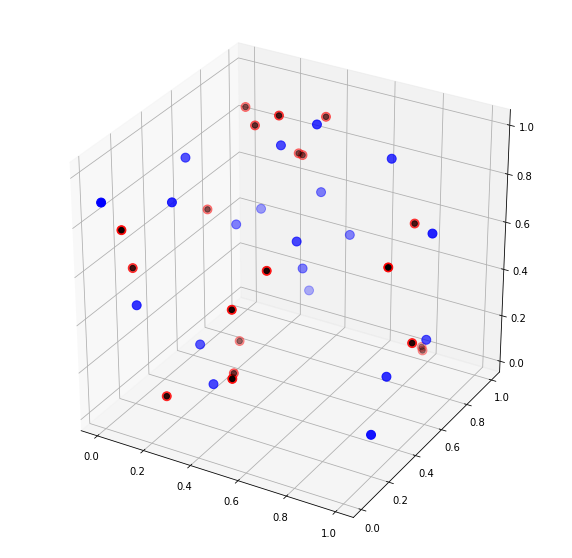

In [11]:
X = np.random.rand(20,3)
Y = np.random.rand(20,3)
Z,sZ,sY = todo_transport3D(X,Y,1000,0.1)      # implement this function
fig = plt.figure(figsize=(10, 10)) 
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(X[:,0],X[:,1],X[:,2],c='blue',s=80)
axis.scatter(Y[:,0],Y[:,1],Y[:,2],c='red',s=80)
axis.scatter(Z[:,0],Z[:,1],Z[:,2],c='black',s=30)
plt.show()

Visualize the displacement of the point cloud $X$ toward $Y$.

## Application to color transfer

First, we subsample both images to reduce the number of points and we create the color point clouds from the subsampled color images.

.
<span style="color:red">
The color transfer can take a very long time if we use images with full resolution! In this practical session, we illustrate the color transfer on full images, but for experimentation, it is adviced to subsample both images by a factor $s$ large enough.</span>



In [12]:
u          = imrgb1
v          = imrgb2
s          = 1                            # choose s=10 or larger in your session!!!
if s==1:
        usubsample = u
        vsubsample = v
else:
        usubsample = u[1::s,1::s,0:3]
        vsubsample = v[1::s,1::s,0:3]
X          = usubsample.reshape((usubsample.shape[0]*usubsample.shape[1],3))
Y          = vsubsample.reshape((vsubsample.shape[0]*vsubsample.shape[1],3))

We display (a subsample of) the corresponding point clouds.

(Text(0.5, 0, 'Red'), Text(0.5, 0, 'Green'), Text(0.5, 0, 'Blue'))

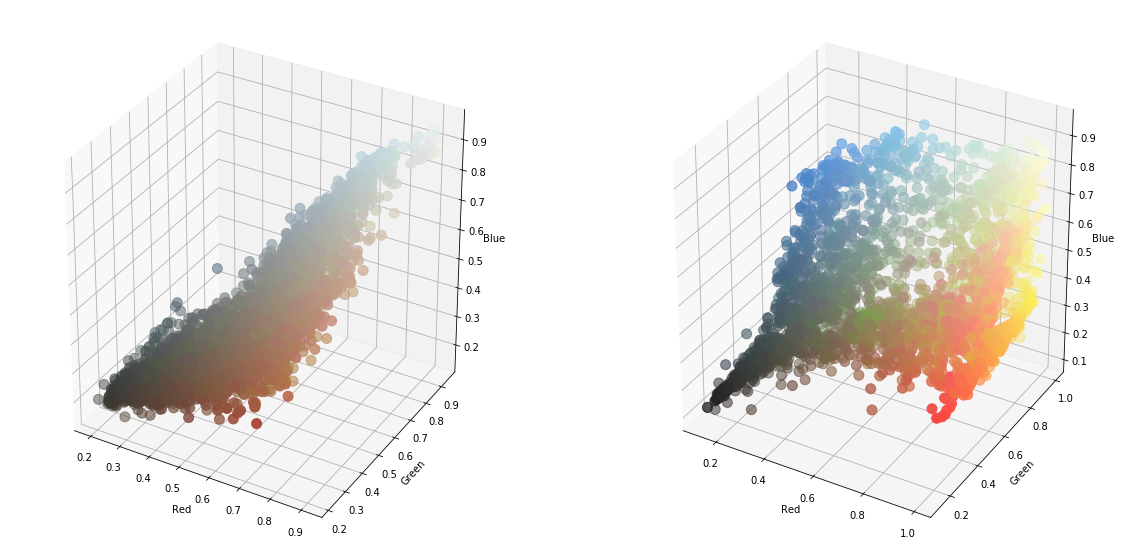

In [13]:
nb   = 3000
r    = np.random.RandomState(42)
idX  = r.randint(X.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Xs   = X[idX, :]
Ys   = Y[idY, :]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=Xs,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue")
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=Ys,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue")

**We apply the previous sliced optimal transport algorithm to compute the optimal assignment between the point clouds $X$ and $Y$.** For each $i$, the 3D point $X[i,:]$ is displaced at the position $X_{new}[i,:]$. Since $X$ is merely a reshaping of the color values of $u$, we obtain the new image $u$ after color transfer by reshaping the array $X_{new}$. 

In [16]:
X_new, order_X_new, s_Y= todo_transport3D(X,Y,1000,0.2)
wsliced = X_new.reshape(usubsample.shape[0],usubsample.shape[1],3)

We can now display the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


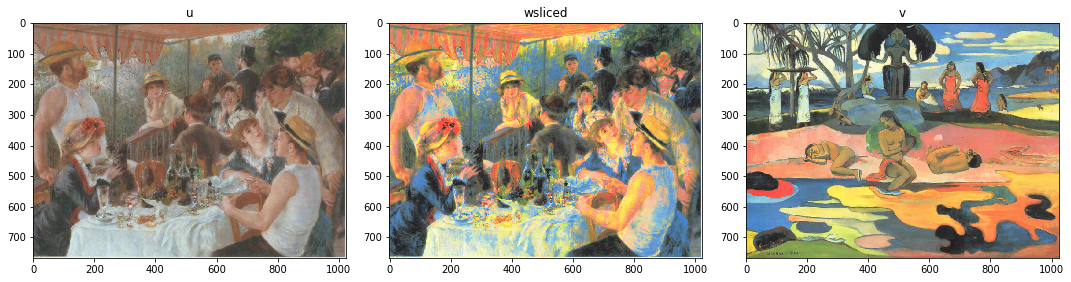

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
axes[0].imshow(usubsample)
axes[0].set_title('u')
axes[1].imshow(wsliced)
axes[1].set_title('wsliced')
axes[2].imshow(vsubsample)
axes[2].set_title('v')
fig.tight_layout()

We display the corresponding color point clouds.

Text(0.5, 0.92, 'Color distribution of the first image after color transfer')

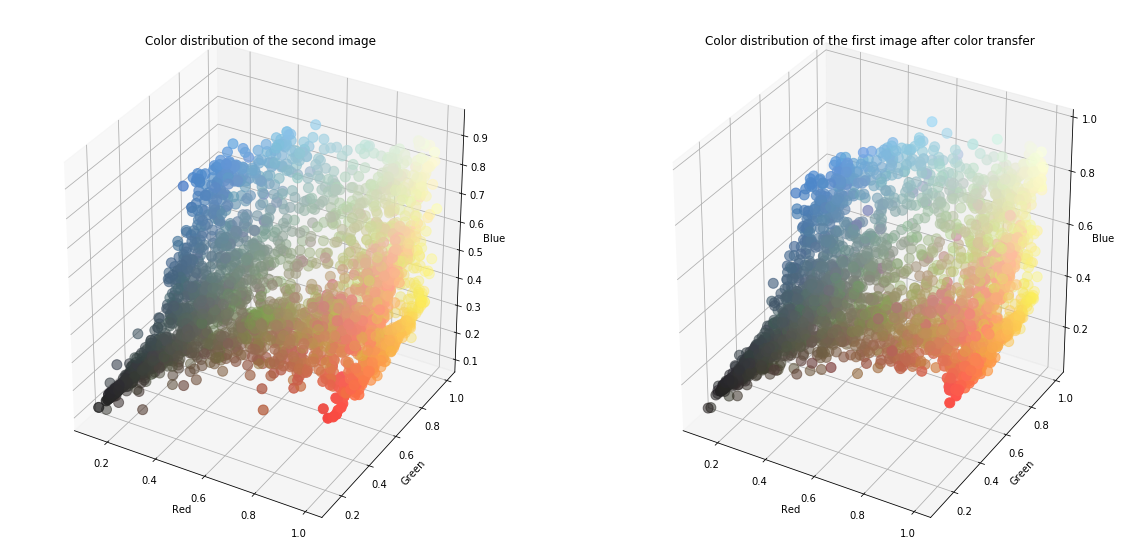

In [23]:
idZ = r.randint(X_new.shape[0], size=(nb,))
Zs = X_new[idZ, :]
Zs = (Zs>1)+(Zs<1)*(Zs>0)*Zs           # to ensure that colors are in [0,1]^3

fig = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=Ys,s=100)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
axis.set_title('Color distribution of the second image')
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Zs[:, 0], Zs[:,1],Zs[:, 2], c=Zs,s=100)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
axis.set_title('Color distribution of the first image after color transfer')

# Postprocessing: Regularization 

Before starting this part, if you have worked with subsampled images in the previous part, you can load the results of the color transfer on full images.

In [4]:
usubsample = plt.imread(path+'renoir.jpg')/255
wsliced    = plt.imread(path+'renoir_by_gauguin.png')
wsliced    = wsliced[:,:,0:3]                          # to remove transparency channel

A common drawback of classical methods aiming at color and contrast modifications is the revealing of artefacts (JPEG blocs, color inconsistancies, noise enhancement) or the attenuation of details and textures (see for instance the following [web page](http://perso.telecom-paristech.fr/~delon/artefact_removal_html/)). 
Let $u$ be an image and $g(u)$ the same  image after color or contrast modification, we write $\mathcal{M}(u) = g(u) - u$. All artefacts observable in $g(u)$ can be seen as irregularities in these difference map $\mathcal{M}(u)$. In order to reduce these artefacts, we propose to filter this difference map thanks to an operator $Y_u$ and to reconstruct the image:

$$T(g(u)) = u + Y_u(g(u)-u).$$

Let us begin with a very simple averaging filter for $Y_u$.

## Simple averaging filter on the difference map

A simple averaging filter can be implemented with the function `convolve2d` of `scipy.signal` for instance.  However, it is much more efficient to compute this average filter thanks to integral images, as follows.

In [5]:
def average_filter(u,r):
    # uniform filter with a square (2*r+1)x(2*r+1) window 
    # u is a 2d image
    # r is the radius for the filter
   
    (nrow, ncol)                                      = u.shape
    big_uint                                          = np.zeros((nrow+2*r+1,ncol+2*r+1))
    big_uint[r+1:nrow+r+1,r+1:ncol+r+1]               = u
    big_uint                                          = np.cumsum(np.cumsum(big_uint,0),1)       # integral image
        
    out = big_uint[2*r+1:nrow+2*r+1,2*r+1:ncol+2*r+1] + big_uint[0:nrow,0:ncol] - big_uint[0:nrow,2*r+1:ncol+2*r+1] - big_uint[2*r+1:nrow+2*r+1,0:ncol]
    out = out/(2*r+1)**2
    
    return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


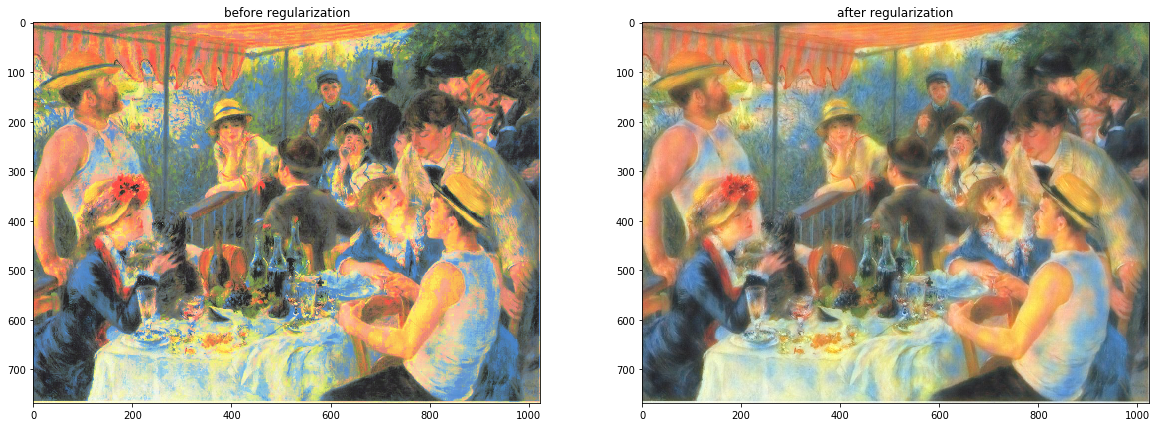

In [6]:
diff = wsliced-usubsample
out = np.zeros_like(usubsample)
r=10
for i in range(3):
    out[:,:,i] = average_filter(diff[:,:,i], r)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(wsliced)
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(usubsample+out)

Let's zoom on the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


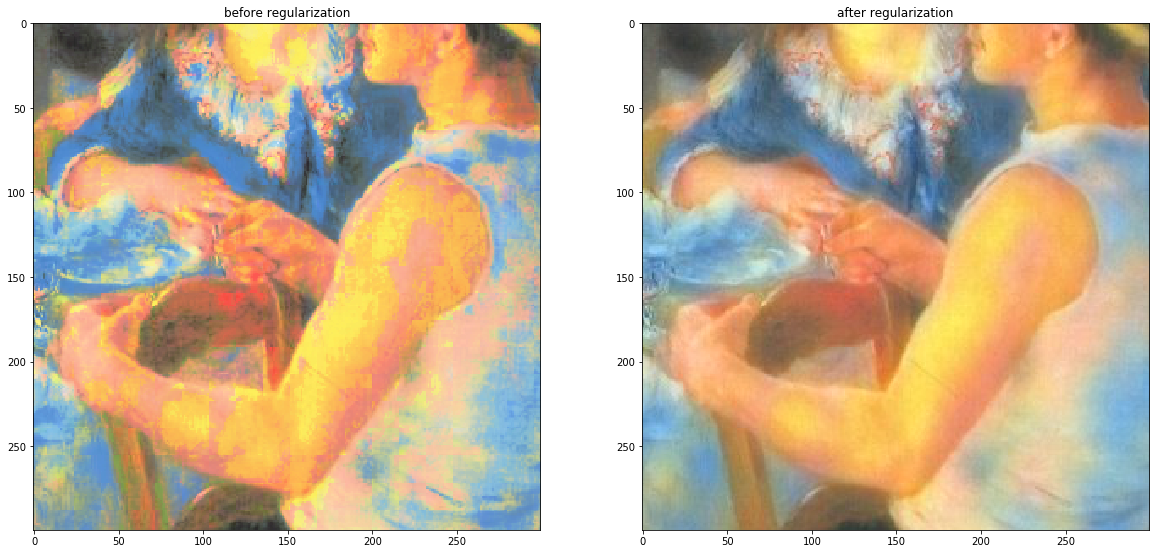

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(wsliced[400:700,600:900,:])
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(usubsample[400:700,600:900,:]+out[400:700,600:900,:])

The result is not bad but some blur appears and is due to the fact that the edges in the image `out` do not coincide anymore with the edges in the original image. 

## Guided filter on the difference map

A more interesting result can be obtained by guiding the filtering of the difference map $\mathcal{M}(u)$ in a way such that it will follow the regularity of $u$. 
To this aim, we define the operator $Y_u$ as the guided filter described in the paper

[*Guided Image Filtering*, Kaiming He1, Jian Sun2, and Xiaoou Tang, ECCV 2010.](http://kaiminghe.com/publications/eccv10guidedfilter.pdf)

The idea is the following: let $u$ be an image that we want to regularize, and $guide$ be a guidance image of the same size. We want to construct an output image $q$ which looks like $u$ but follows the regularity of $guide$. To this aim, we will try to ensure that the gradient of $q$ is (almost) proportional to the gradient of $guide$. The algorithm is as follows (see page 4 of the aforementioned paper):

1. For each pixel $k$ of $u$, let $\omega_k$ be a square window centered at $k$, we look for coefficients $a_k$ and $b_k$ which minimizes the euclidean distance between $u$ and the linear transform $q = a_k guide + b_k$ on $\omega_k$. The solution is given by linear regression, i.e. 

$$a_k = \frac{\frac{1}{|\omega_k|}\sum_{i\in \omega_k} guide(i)u(i) - \mathrm{mean}(u)_k \mathrm{mean}(I)_k}{\sigma(I)_k^2}$$
$$b_k =  \mathrm{mean}(u)_k-a_k \mathrm{mean}(I)_k$$

where $\mathrm{mean}(I)_k$ is the average value of $I$ on $\omega_k$ and $\sigma(I)_k^2$ is the empirical variance of $I$ on $\omega_k$.  

2. The previous step yields a grid of linear coefficients $(a_k,b_k)$. Since each pixel $k$ belongs to several windows, we average these coefficients on each window $\omega$ to obtain new coefficients $(\bar{a}_k,\bar{b}_k)$, and the final image is obtained as

$$q(k) = \bar{a}_k guide(k) + \bar{b}_k.$$


- **Write a function `todo_guided_filter` which computes the filter described above.** The function should take as input two gray level images $u$ and $guide$, an integer $r$ and a regularization parameter $\epsilon$, and should ouput a gray level image. **Everything can be implemented without `for` loops**, with 2D convolutions (function `convolve2d` of `scipy.signal`) or much more efficiently with the $O(1)$ `average_filter` function using integral images that we defined above.  
  
- Apply the previous filter to $\mathcal{M}(u)$ and display the result $T(g(u))$. You can use $\epsilon = 10^{-4}$ and $r=20$ for instance.

In [7]:
diff = wsliced-usubsample
out = np.zeros_like(usubsample)

for i in range(3):
    out[:,:,i] = todo_guided_filter(diff[:,:,i], usubsample[:,:,i], 20,1e-4 )

We display the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


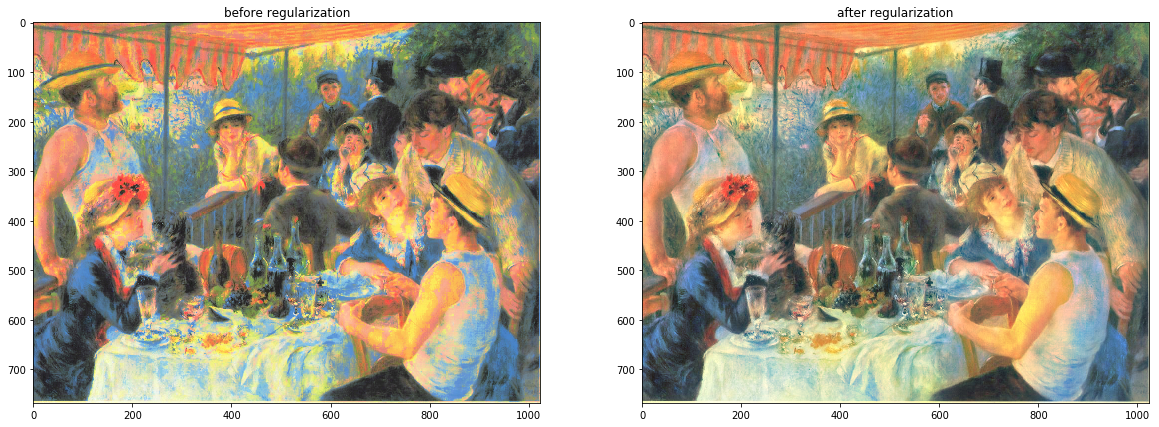

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(wsliced)
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(out+usubsample)

Zoom on the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


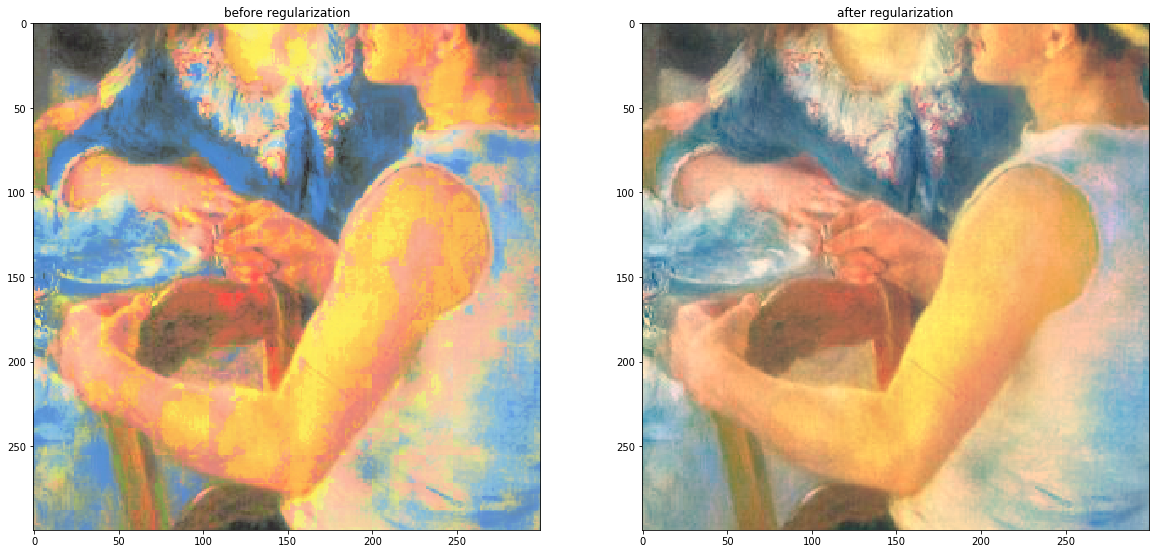

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
axes[0].imshow(wsliced[400:700,600:900,:])
axes[0].set_title('before regularization')
axes[1].set_title('after regularization')
axes[1].imshow(usubsample[400:700,600:900,:]+out[400:700,600:900,:])

## Barycenter and midway

Knowing the optimal (or an approximation) assignment between the point clouds $X$ and $Y$, you can compute barycenters between these discrete distributions. Hence you can compute the midway color distributions of a set of images.